In [1]:
#Импортирование библиотек
from Timage import Timage
import numpy as np
import scipy.io as sc
from PIL import Image
from tqdm import trange

m = sc.loadmat('resources/mat_files/part1.mat')

#Берет n-ое изображение из sector_one.mat
def get_timage(n):
    global m
    arr = np.array([[m['A'][j][i][n] for j in range(len(m['A']))] for i in range(len(m['A']))], dtype=np.float32)
    return Timage(array=arr)

In [2]:
class DefectMap:
    def __init__(self, array):
        self.array = array
    
    def direct(self, direction, contrast_level, pallete):
        np_pallete = np.array(pallete, dtype=np.float32)
        
        directed = 128 - np.real(self.array * np.conjugate(direction)) 

        mean = np.mean(directed)
        f = lambda x: (x - mean) / (1 - contrast_level) + mean
        contrasted = directed.copy()

        m, n = len(directed), len(directed[0])
        for i in range(m):
            for j in range(n):
                contrasted[i][j] = min(255, max(0,   f(float(directed[i][j]))  ))

        colored = np.multiply.outer(contrasted, np_pallete[1]/255) + np.multiply.outer(255-contrasted, np_pallete[0]/255)
        return colored

In [ ]:
исправить широкоугольное искажение
срастить секторы термограммы

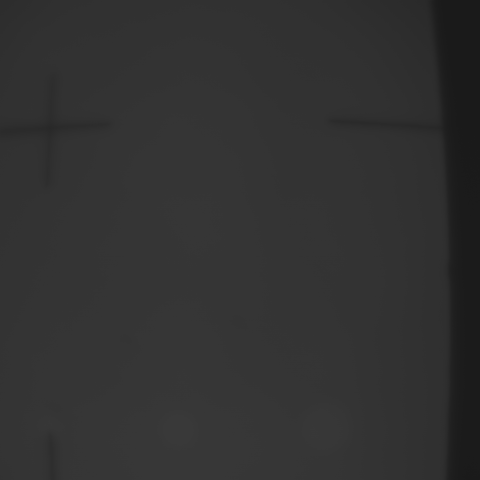

In [2]:
tim = get_timage(60)
tim.show()
#arr = np.zeros((501, 501), dtype=np.float32)
#step = 25
#arr[::step] = 255
#arr[:,::step] = 255
#for i in range(1, 1):
#    arr[i::step] = 255
#    arr[:, i::step] = 255
#    arr[step-i::step] = 255
#    arr[:, step-i::step] = 255
#
#arr[:step] = 255
#
#tim = Timage(array=arr)
#tim.show()

In [ ]:
from math import sin
arr = np.zeros((100, 100), dtype=np.float32)

for i in range(len(arr)):
    for j in range(len(arr[0])):
        r = (  (i - len(arr)/2)**2 + (j - len(arr)/2)**2  ) ** 0.5
        if sin(r/2) >= 0: arr[i,j] = 255
tim = Timage(array=arr)
tim.show()

In [ ]:
arr = np.zeros((301, 301), dtype=np.float32)

for i in range(len(arr)):
    for j in range(len(arr)):
        arr[i, j] = 127.5 * i / (len(arr) - 1) + 127.5 * j / (len(arr) - 1)

step = 15
arr[::step] = 255 - arr[::step]
for i in range(1, step): arr[i::step,::step] = 255 - arr[i::step, ::step]

tim = Timage(array=arr)
tim.show()

In [7]:
def f(x, y, undistorted_center, distorted_center, ki, scale): # Brown-Conrady's even-order polynomial model
    x /= undistorted_center[0]
    y /= undistorted_center[1]

    r = (  (x - 1)**2 + (y - 1)**2  ) ** 0.5 / scale
    k = sum(ki[i] * (r ** (2*i)) for i in range(len(ki)))
    #if k < 0: return (float('inf'), float('inf'), 'fl')

    x_distorted = distorted_center[0] + (x - 1) * k * undistorted_center[0]
    y_distorted = distorted_center[1] + (y - 1) * k * undistorted_center[1]
    return (x_distorted, y_distorted, 'fl')

In [9]:
ki = [1, -0.000018, 0.00048/10**6] # for camera, scale = 4
#ki = [1, -0.0001]

new = np.zeros((tim.array.shape[0]*3, tim.array.shape[1]*3), dtype=np.float32)
undistorted_center, distorted_center = (len(new)/2, len(new[0])/2), (len(tim.array)/2, len(tim.array[0])/2)
for i in trange(len(new)):
    for j in range(len(new[0])):
        new[i][j] = tim[f(i, j, undistorted_center, distorted_center, ki, 4)]

t = Timage(array=new)
t.show(contrast_level=0.94).show()

100%|██████████| 1440/1440 [00:05<00:00, 282.66it/s]


In [ ]:
from moviepy import ImageSequenceClip
from os import listdir

output_video = "distortion_expanded.mp4"
fps = 60

files = sorted(listdir('temp'), key= lambda x: float(x[:-4]))

clip = ImageSequenceClip(['temp/'+file for file in files], fps=fps)

clip.write_videofile(output_video, audio=False)

In [33]:
tim.show(contrast_level=0.9).save('results/60_distortion_before.png')
tim.distorted([1, -0.2, 0.1], scale=2).show(contrast_level=0.9).save('results/60_distortion_after.png')

100%|██████████| 960/960 [00:03<00:00, 266.05it/s]
